In [1]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 
from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image
import os
import random

In [2]:
N_MATCHES = 300
s = 4
N_RANSAC = 1000
INLIER_THRESHOLD = 1

4407


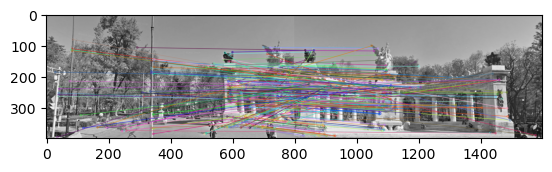

(398, 800)


In [3]:
img1 = cv2.imread('left.jpg',0) # queryImage
img2 = cv2.imread('right.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

print(len(matches))

# Select top N matches
putatives = matches[:N_MATCHES]

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, putatives[:10], None, flags=2)

plt.imshow(img3),plt.show()

print(img1.shape)

In [4]:
# Provided code for plotting inlier matches between two images
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# constructs matrix A from lecture, projects locations from left image 
# onto locations in right image
def construct_A(l_homo_coords, r_homo_coords):
    zero_T = np.zeros(3)
    A = np.empty((8,9))
    for i in range(s):
        x_T = l_homo_coords[i]
        row_1 = np.hstack((zero_T, x_T, -1 * r_homo_coords[i][1] * x_T))
        row_2 = np.hstack((x_T, zero_T, -1 * r_homo_coords[i][0] * x_T))
        A[2*i] = row_1
        A[2*i+1] = row_2
    return A

# convert 2D homogeneous coords to regular 2D coords
def homo_to_norm(homo_coords):
    return np.array((homo_coords[0] / homo_coords[2], homo_coords[1] / homo_coords[2]))

# warp a point using a homography matrix
def warp_point(normal_coords, homo_matrix):
    # convert coordinates to homogenous coordinates
    homo_coords = np.array(normal_coords + (1,))
    # compute Hx, projected coordinates of homo_coords
    proj_homo_coords = np.matmul(homo_matrix, homo_coords)
    # convert projected homo coordinates back to normal coordinates
    return homo_to_norm(proj_homo_coords) 

# compute inliers and avg residuals for given homography
def compute_inliers(putatives, l_kps, r_kps, homo_matrix):
    num_inliers = 0
    total_residuals = 0.
    inliers = []
    # cycle through all putatives for inliers
    for i in range(len(putatives)):
        # normal coordinates for both points
        r_coords = r_kps[matches[i].trainIdx].pt
        l_coords = l_kps[matches[i].queryIdx].pt
        # warp point with homography matrix
        proj_l_coords = warp_point(l_coords, homo_matrix)
        # compute SSD between projected left coords and known right coords
        residual = np.sum((r_coords - proj_l_coords)**2)
        # if less than threshold, count it
        if residual < INLIER_THRESHOLD:
            num_inliers += 1
            total_residuals += residual
            # append inlier as 1D array of length 4 (leftcoords, rightcoords
            inliers.append(np.hstack((l_coords, r_coords)))    
    return np.array(inliers), total_residuals / num_inliers

# RANSAC PARAMETERS
def RANSAC(putatives, l_kps, r_kps):
    # our return values
    best_num_inliers = 0
    best_avg_inlier_residual = 0
    best_homo_matrix = np.empty((3,3))
    best_inliers = []
    
    # iterate N_RANSAC times
    for i in range(N_RANSAC):
        # draw s(4) points at random 
        matches = random.sample(putatives, s)
        # translate to homogeneous coordinates
        coords_left = np.array([np.array(l_kps[matches[i].queryIdx].pt + (1,)) for i in range(s)])
        coords_right = np.array([np.array(r_kps[matches[i].trainIdx].pt + (1,)) for i in range(s)])
        # construct matrix A as described in lecture
        A = construct_A(coords_left, coords_right)
        # find solution for homography matrix H
        U_, s_, v_ = np.linalg.svd(A)
        min_s_val = v_[-1]
        homo_matrix = min_s_val.reshape((3,3))
        # use H to compute inliers
        inliers, avg_residual = compute_inliers(putatives, l_kps, r_kps, homo_matrix)
        num_inliers = len(inliers)
        # update best homography
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_avg_inlier_residual = avg_residual
            best_homo_matrix = homo_matrix
            best_inliers = inliers
    return best_inliers, best_avg_inlier_residual, best_homo_matrix

In [5]:
# actual RANSAC calculation
best_inliers, best_avg_inlier_residual, best_homo_matrix = RANSAC(putatives, kp1, kp2)

Best average inlier residual: 0.34642941633167673
Number of inliers: 52


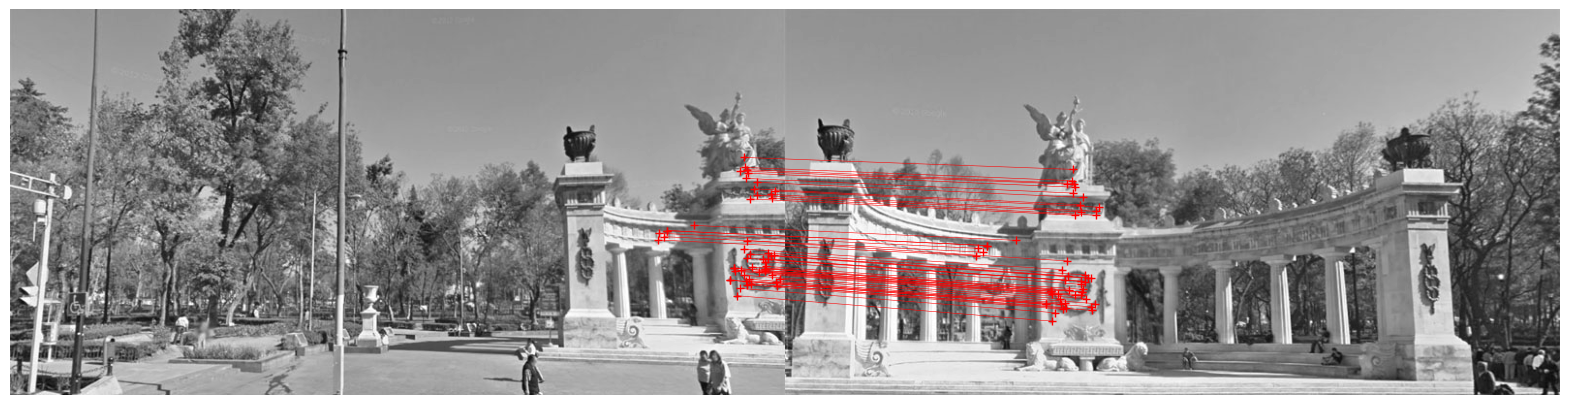

In [6]:
# statistics and visualization
print("Best average inlier residual: " + str(best_avg_inlier_residual))
print("Number of inliers: " + str(len(best_inliers)))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, best_inliers)

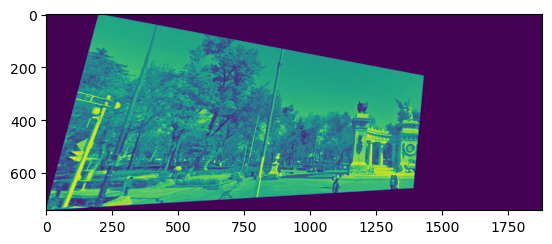

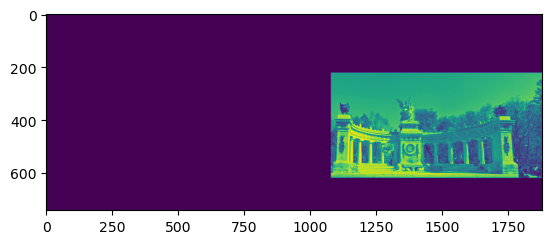

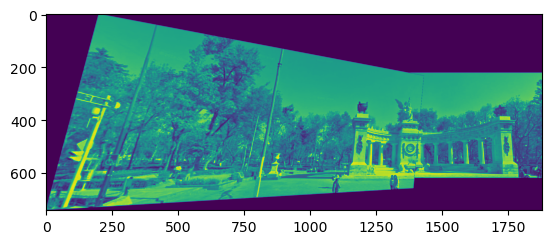

In [7]:
# calculate dims of transformed image
max_y, max_x = np.array(img1).shape
corner_points = [(0, 0), (max_x, 0), (0, max_y),  (max_x, max_y)]
transformed_coords = np.array([warp_point(corner_point, best_homo_matrix) for corner_point in corner_points])
min_x = np.min(transformed_coords[:,0])
min_y = np.min(transformed_coords[:,1])
max_x = np.max(transformed_coords[:,0])
max_y = np.max(transformed_coords[:,1])
height = int(max_y - min_y)
width = int(max_x - min_x)

# dimensions are max of shifted warped img1 and shifted img2
dims = (max(height, int(img1.shape[0] - min_y)), max(width, int(img1.shape[1] - min_x)))

# form product of translation and homography matrix to get img1's transform
translation_matrix = np.array([[1, 0, -min_x],[0, 1, -min_y],[0, 0, 1]])
translate_warp_matrix = np.matmul(translation_matrix, best_homo_matrix)

# warp img1 with homography and translation
tf = skimage.transform.ProjectiveTransform(matrix=translate_warp_matrix)
warped_img_1 = skimage.transform.warp(img1, tf.inverse, output_shape=dims)

# warp img2 with translation only
translation_matrix_2 = np.array([[1, 0, -min_x],[0, 1, -min_y]])
img2_shifted = cv2.warpAffine(img2, translation_matrix_2, (dims[1], dims[0]))

plt.imshow(warped_img_1)
plt.show()
plt.imshow(img2_shifted)
plt.show()

img2_final = img2_shifted / 255

# combine images
combined_image = np.zeros(dims)
for i in range(0, dims[0]):
    for j in range(0, dims[1]):
        img_1_pt = warped_img_1[i][j]
        img_2_pt = img2_final[i][j]
        # img2 is non-zero
        if img_1_pt == 0 and img_2_pt != 0:
            combined_image[i][j] = img_2_pt
        # img1 is non-zero
        elif img_1_pt != 0 and img_2_pt == 0:
            combined_image[i][j] = img_1_pt
        # both are non-zero
        elif img_1_pt != 0 and img_2_pt != 0:
            combined_image[i][j] = img_1_pt #(img_1_pt + img_2_pt) / 2
        # both are 0
        else:  
            combined_image[i][j] = 0
            
plt.imshow(combined_image)
plt.show()